# Определение стоимости автомобилей

# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Признаки**


- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя


**Целевой признак**

- `Price` — цена (евро)

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

### Анализ данных

In [2]:
#Выгрузим данные из таблицы и изучим их.
autos_data = pd.read_csv('/datasets/autos.csv')
display(autos_data.info())
autos_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         354369 non-null  int64 
 1   DateCrawled        354369 non-null  object
 2   Price              354369 non-null  int64 
 3   VehicleType        316879 non-null  object
 4   RegistrationYear   354369 non-null  int64 
 5   Gearbox            334536 non-null  object
 6   Power              354369 non-null  int64 
 7   Model              334664 non-null  object
 8   Kilometer          354369 non-null  int64 
 9   RegistrationMonth  354369 non-null  int64 
 10  FuelType           321474 non-null  object
 11  Brand              354369 non-null  object
 12  Repaired           283215 non-null  object
 13  DateCreated        354369 non-null  object
 14  NumberOfPictures   354369 non-null  int64 
 15  PostalCode         354369 non-null  int64 
 16  LastSeen           3

None

,Unnamed: 0,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
#Оценим количество пропусков по каждому критерию.
autos_data.isna().mean()

Unnamed: 0           0.000000
DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [4]:
#Столбцы VehicleType, Gearbox, FuelType и NotRepaired обладают пропусками. Изучим, какие данные есть в каждом столбце.
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())
show_rows(autos_data)

Уникальные значения столбца Unnamed: 0
[     0      1      2 ... 354366 354367 354368]
Уникальные значения столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 195

**Вывод по пункту 1.1.**

В столбце ***RegistrationYear*** существуют некорректные значения года регистрации.

В столбце ***RegistrationMonth*** отсутсвует месяц регистрации.

В столбце ***Power*** присутвует некорректное значение мощности.

**К значимым признакам отнесем следующие столбцы:**

* ***VehicleType.*** Тип машины определяет ее функционал. Чем больше возможносей у машины, тем выше цена.

* ***Gearbox.*** Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.

* ***Power.*** Мощность в лоашдиных силах (далее л.с.) напрямую влияют на цену.

* ***Kilometer.*** Имеет обратно пропорциональную зависиммость от цены. Чем больше километров проехала машина, тем меньше ее надежность и соответсвенно цена.

* ***FuelType.*** Тип топлива определяет конструкцию двигателя внутреннего сгорания.

* ***Brand.*** Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.

* ***Repaired.*** Машины, которые побывали в дорожно-транспортных проишествиях означает, что машина подвергалась изменениям и ее надежность ниже.

* ***RegistrationYear.*** Год регистрации определяет сколько уже лет машина на ходу. соответвенно, чем больше возраст, тем меньше цена.

* ***Model.*** В купе с типом машины и брендом може влиять на популярность у покупателей.

*Остальные столбцы для модели не требуются, так как не влияют на стоимость.*

### Предобработка данных

In [5]:
#Сократим дата фрейм до нужных столбцов.
filtred_autos_data = autos_data[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Gearbox           334536 non-null  object
 2   Power             354369 non-null  int64 
 3   Kilometer         354369 non-null  int64 
 4   FuelType          321474 non-null  object
 5   Brand             354369 non-null  object
 6   Repaired          283215 non-null  object
 7   RegistrationYear  354369 non-null  int64 
 8   Model             334664 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Столбцы, требующие обработки:

* ***VehicleType.*** Восстановим пропущенные значения по популярному типу из столбца Brand.
* ***Gearbox.*** Для всех NaN установим значение 'manual'.
* ***Power.*** Скоректируем на основе реальных значений в машинах. Иметь 1 л.с. или 15000 л.с. для машины на данный момент нереально.
* ***FuelType.*** Восстановим пропущенные значения по популярному типу из столбца Brand.
* ***Repaired.*** Для всех NaN установим значение 'yes'.
* ***RegistrationYear.*** Скоректируем на основе реальных значений в машинах.
* ***Model.*** Для всех NaN установим значение 'unknown'.

In [6]:
#Проверим наполнение целевого признака Price.
filtred_autos_data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64

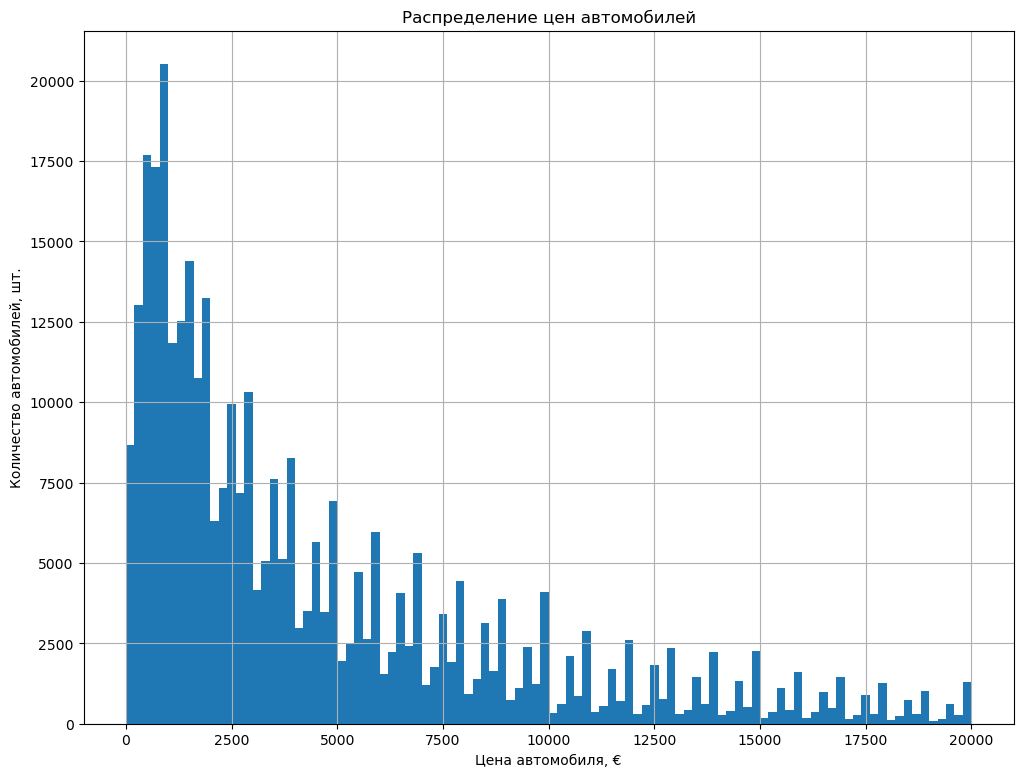

In [7]:
#Видно, что существует 10772 записи без цены. Удалим их и проверим распределение цены на гистограмме.
filtred_autos_data = filtred_autos_data.query('Price > 0')
filtred_autos_data['Price'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Price'].describe()
plt.title('Распределение цен автомобилей')
plt.xlabel('Цена автомобиля, €')
plt.ylabel('Количество автомобилей, шт.');

In [8]:
#Выделим квантили 5% и 80%.
filtred_autos_data['Price'].quantile([.05, 0.8])

0.05     350.0
0.80    7800.0
Name: Price, dtype: float64

In [9]:
#Стоимость 350 евро примерно равно 28000 рублей. 
#Это минимальная цена для продажи поддержанного авто. Выбор 80% квантиля обоснован болльшими выбросами после 7500 евро.
filtred_autos_data = filtred_autos_data.query('350 <= Price <= 7800')
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259798 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233267 non-null  object
 1   Gearbox           246646 non-null  object
 2   Power             259798 non-null  int64 
 3   Kilometer         259798 non-null  int64 
 4   FuelType          236972 non-null  object
 5   Brand             259798 non-null  object
 6   Repaired          206998 non-null  object
 7   RegistrationYear  259798 non-null  int64 
 8   Model             246358 non-null  object
 9   Price             259798 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 21.8+ MB


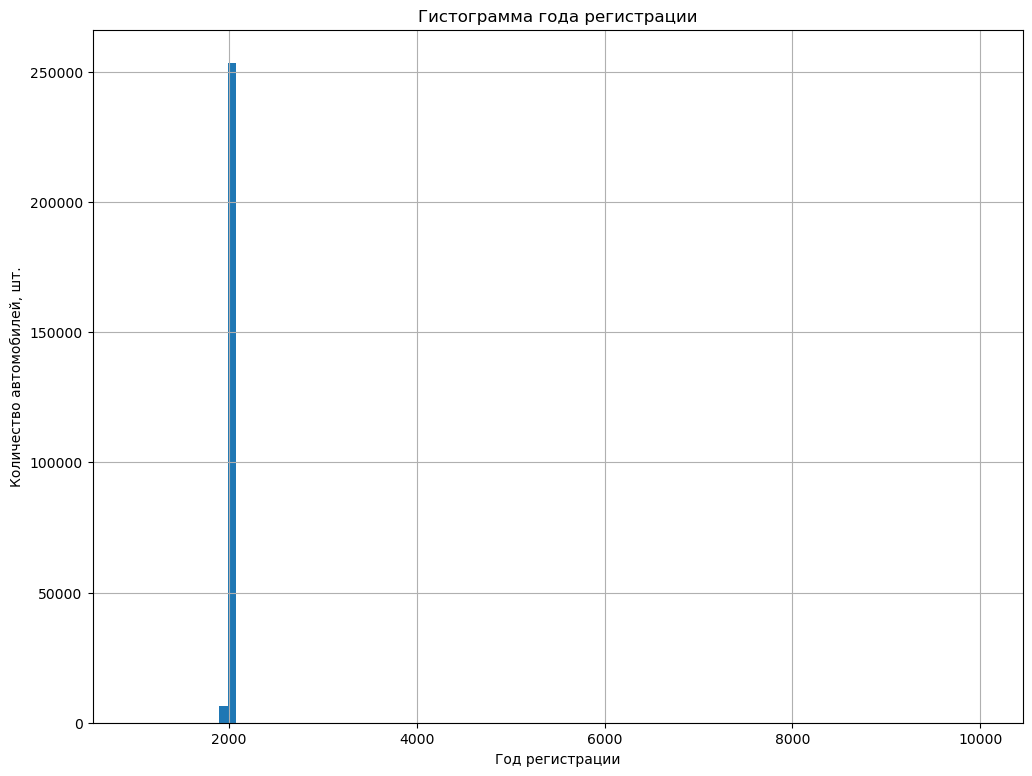

In [10]:
#Проверим значения столбца RegistrationYear на гистограмме.
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()
plt.title('Гистограмма года регистрации')
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей, шт.');

In [11]:
#В годе регистрации наблюдаются выбросы. Отсечем правые выбросы, узнав максимальную дату скачивания анкеты автомобиля.
date = pd.to_datetime(autos_data['DateCrawled'])
date.max()

Timestamp('2016-04-07 14:36:58')

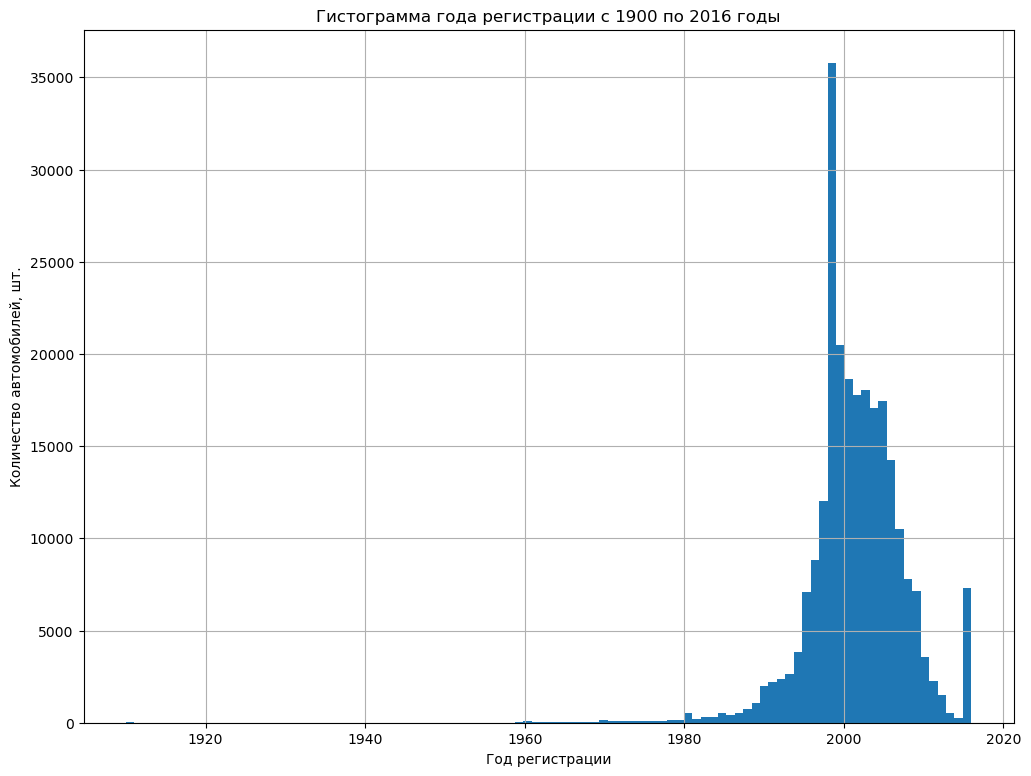

In [12]:
#Даты регистрации после 2016 года некорректны и машины появились не раньше 1900 года. 
#Отсечем ненужные года и промотрим левые выбросы.
filtred_autos_data = filtred_autos_data.query('1899 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()
plt.title('Гистограмма года регистрации с 1900 по 2016 годы')
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей, шт.');

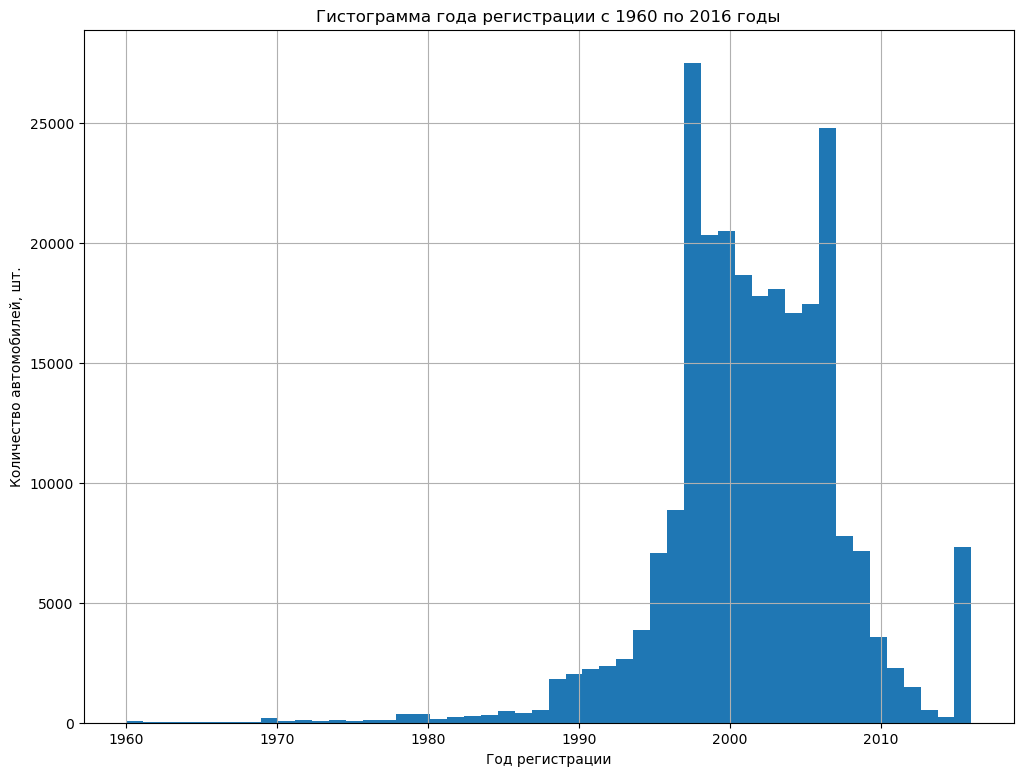

In [13]:
#По левой части гистограммы видно, что адекватно использовать левую границу в 1960 год, 
#так как это старые, но возможно еще работающие машины.
filtred_autos_data = filtred_autos_data.query('1959 < RegistrationYear < 2017')
filtred_autos_data['RegistrationYear'].hist(bins=50, figsize=(12,9))
filtred_autos_data['RegistrationYear'].describe()
plt.title('Гистограмма года регистрации с 1960 по 2016 годы')
plt.xlabel('Год регистрации')
plt.ylabel('Количество автомобилей, шт.');

In [14]:
#Проведем замену NaN в Gearbox, NotRepaired и Model.
filtred_autos_data.fillna({'Gearbox':'unknown', 
                           'NotRepaired':'unknown',
                           'Model':'unknown'},
                          inplace=True)
filtred_autos_data.isna().mean()

VehicleType         0.058640
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.073575
Brand               0.000000
Repaired            0.191489
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

In [15]:
#Оценим количество пропущенных значений относительно всех значений в столбце VehicleType
display(filtred_autos_data['VehicleType'].value_counts())
filtred_autos_data['VehicleType'].isna().sum()

sedan          67609
small          66486
wagon          47300
bus            21087
convertible    12662
coupe          10311
suv             5237
other           2450
Name: VehicleType, dtype: int64

14523

In [16]:
#Выполним замену NaN в соотвествии с популярным типом кузова для каждого бренда.

vehicle_type_pivot_table = filtred_autos_data.pivot_table(index=['VehicleType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
display(vehicle_type_pivot_table)
filtred_autos_data[filtred_autos_data['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      4.0      98.0    370.0  1040.0   15.0   
convertible      111.0   667.0   1636.0       6.0    195.0    96.0    NaN   
coupe            180.0   651.0   2570.0      45.0     17.0   137.0    NaN   
other             10.0    83.0    187.0      18.0      6.0    95.0    5.0   
sedan            777.0  7828.0  11309.0     146.0    205.0   538.0   97.0   
small            185.0   933.0    324.0     574.0     12.0  1372.0  178.0   
suv                NaN    18.0    189.0     146.0     12.0     8.0   46.0   
wagon            388.0  6422.0   4997.0      83.0    183.0   497.0  227.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           26.0     31.0   707.0  ...   485.0   158.0     1.0   
convertible    1.0      8.0   257.0  ...     NaN     3.0   988.0   
coupe          2.0      NaN   151.0  ...    64.0     6.0   318.0   
other          5.0      9.0   151.0  ...    47.0    21.0     8.0   
sedan         87.0     35.0   796.0  ...  1220.0   694.0    26.0   
small        247.0    439.0  4520.0  ...  2621.0   930.0  3099.0   
suv            1.0     46.0    17.0  ...     1.0     7.0     NaN   
wagon         36.0     16.0   370.0  ...   215.0  1763.0     9.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  140.0   16.0   27.0   341.0     NaN     5936.0     NaN  
convertible          161.0    NaN   32.0    47.0    30.0     2029.0    35.0  
coupe                 79.0    3.0    4.0   178.0     2.0      740.0    50.0  
other                167.0    5.0   10.0    15.0     4.0      586.0     NaN  
sedan                257.0   99.0  131.0   735.0   170.0    14847.0   487.0  
small                166.0   99.0  810.0  1475.0    49.0    15294.0     6.0  
suv                  174.0   42.0  557.0   252.0     NaN      247.0    30.0  
wagon                104.0  241.0   84.0   449.0    66.0     9704.0  1655.0  

[8 rows x 40 columns]

sedan          777
wagon          388
small          185
coupe          180
convertible    111
other           10
Name: VehicleType, dtype: int64

In [17]:
vehicle_type_pivot_table = vehicle_type_pivot_table['count']['Price']
vehicle_type_pivot_table

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,4.0,98.0,370.0,1040.0,15.0,26.0,31.0,707.0,...,485.0,158.0,1.0,140.0,16.0,27.0,341.0,NaN,5936.0,NaN
convertible,111.0,667.0,1636.0,6.0,195.0,96.0,NaN,1.0,8.0,257.0,...,NaN,3.0,988.0,161.0,NaN,32.0,47.0,30.0,2029.0,35.0
coupe,180.0,651.0,2570.0,45.0,17.0,137.0,NaN,2.0,NaN,151.0,...,64.0,6.0,318.0,79.0,3.0,4.0,178.0,2.0,740.0,50.0
other,10.0,83.0,187.0,18.0,6.0,95.0,5.0,5.0,9.0,151.0,...,47.0,21.0,8.0,167.0,5.0,10.0,15.0,4.0,586.0,NaN
sedan,777.0,7828.0,11309.0,146.0,205.0,538.0,97.0,87.0,35.0,796.0,...,1220.0,694.0,26.0,257.0,99.0,131.0,735.0,170.0,14847.0,487.0
small,185.0,933.0,324.0,574.0,12.0,1372.0,178.0,247.0,439.0,4520.0,...,2621.0,930.0,3099.0,166.0,99.0,810.0,1475.0,49.0,15294.0,6.0
suv,NaN,18.0,189.0,146.0,12.0,8.0,46.0,1.0,46.0,17.0,...,1.0,7.0,NaN,174.0,42.0,557.0,252.0,NaN,247.0,30.0
wagon,388.0,6422.0,4997.0,83.0,183.0,497.0,227.0,36.0,16.0,370.0,...,215.0,1763.0,9.0,104.0,241.0,84.0,449.0,66.0,9704.0,1655.0


In [18]:
#Заполним словарь брендов и популярных типов машин и заполним пропуски по столбцу VehicleType.
filtred_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247665 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       233142 non-null  object
 1   Gearbox           247665 non-null  object
 2   Power             247665 non-null  int64 
 3   Kilometer         247665 non-null  int64 
 4   FuelType          229443 non-null  object
 5   Brand             247665 non-null  object
 6   Repaired          200240 non-null  object
 7   RegistrationYear  247665 non-null  int64 
 8   Model             247665 non-null  object
 9   Price             247665 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.8+ MB


In [19]:
filtred_autos_data.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type_pivot_table):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot_table[brand].idxmax()
    return fill_value

filtred_autos_data['VehicleType'] = filtred_autos_data.apply(
                                fillna_by_brand, 
                                args=[0, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['VehicleType'].isna().sum())
filtred_autos_data['VehicleType'].value_counts()

0

small          76545
sedan          71693
wagon          47556
bus            21144
convertible    12662
coupe          10330
suv             5285
other           2450
Name: VehicleType, dtype: int64

In [20]:
#Заполним пропуски в FuelType по похожему принципу.
filtred_autos_data['FuelType'].value_counts()
fuel_type_pivot_table = filtred_autos_data.pivot_table(index=['FuelType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
fuel_type_pivot_table = fuel_type_pivot_table['count']['Price']
display(fuel_type_pivot_table)

filtred_autos_data.fillna({'FuelType':0},inplace=True)

filtred_autos_data['FuelType'] = filtred_autos_data.apply(
                                fillna_by_brand, 
                                args=[4, vehicle_type_pivot_table],
                                axis=1)
display(filtred_autos_data['FuelType'].isna().sum())
filtred_autos_data['FuelType'].value_counts()

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,6.0,4.0,NaN,7.0,2.0,NaN,NaN,63.0,...,NaN,4.0,2.0,NaN,2.0,NaN,NaN,NaN,125.0,14.0
electric,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,NaN,NaN,1.0,16.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,480.0,6502.0,5073.0,66.0,264.0,1181.0,98.0,1.0,4.0,1243.0,...,1229.0,1145.0,807.0,297.0,10.0,145.0,679.0,1.0,16655.0,582.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,NaN,NaN,NaN,35.0,NaN,5.0,NaN
lpg,30.0,356.0,606.0,139.0,77.0,63.0,35.0,23.0,5.0,64.0,...,56.0,48.0,3.0,58.0,25.0,18.0,18.0,NaN,454.0,100.0
other,NaN,2.0,5.0,NaN,NaN,2.0,NaN,1.0,NaN,3.0,...,NaN,NaN,1.0,16.0,NaN,1.0,NaN,31.0,14.0,2.0
petrol,1124.0,9465.0,14948.0,884.0,642.0,2499.0,424.0,374.0,564.0,5496.0,...,3333.0,2333.0,3604.0,784.0,453.0,1457.0,2736.0,242.0,31839.0,1507.0


0

petrol      162858
gasoline     61661
small        12152
sedan         5523
lpg           4241
cng            431
wagon          390
other          115
hybrid          83
bus             74
suv             62
electric        54
coupe           21
Name: FuelType, dtype: int64

In [21]:
filtred_autos_data.isna().mean()

VehicleType         0.000000
Gearbox             0.000000
Power               0.000000
Kilometer           0.000000
FuelType            0.000000
Brand               0.000000
Repaired            0.191489
RegistrationYear    0.000000
Model               0.000000
Price               0.000000
dtype: float64

In [22]:
filtred_autos_data.fillna('Repaired', inplace=True)

In [23]:
filtred_autos_data.isna().mean()

VehicleType         0.0
Gearbox             0.0
Power               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
RegistrationYear    0.0
Model               0.0
Price               0.0
dtype: float64

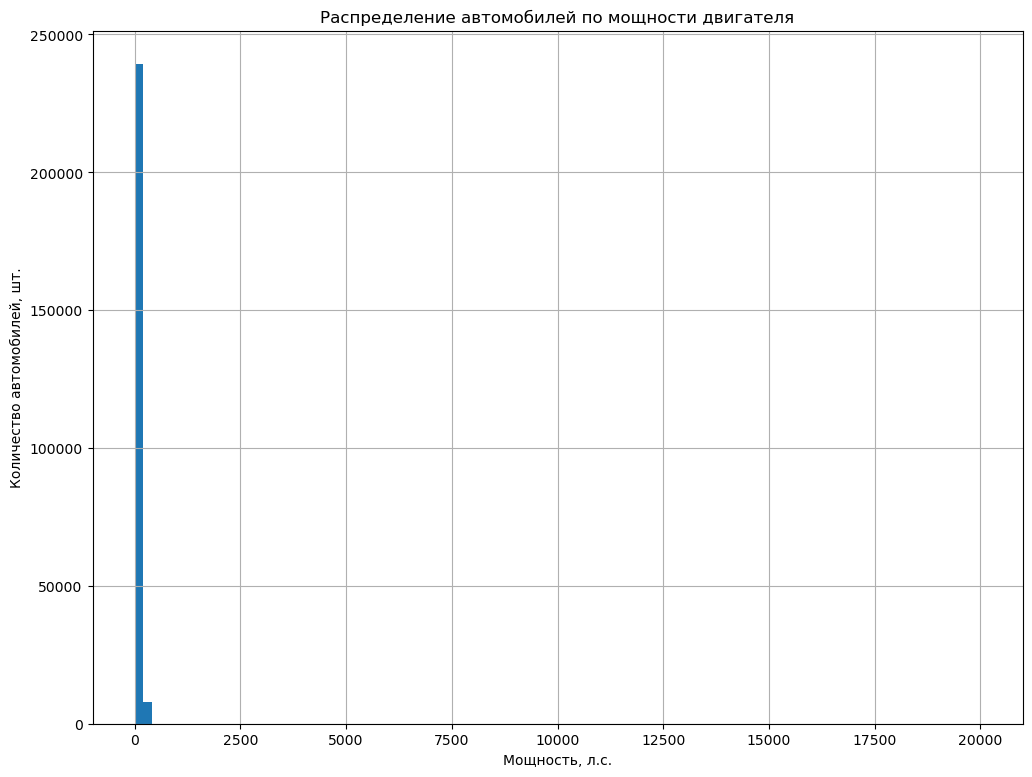

In [24]:
#Пропуски убраны. Осталось заняться некорректнымми значениями в столбце Power.
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()
plt.title('Распределение автомобилей по мощности двигателя')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей, шт.');

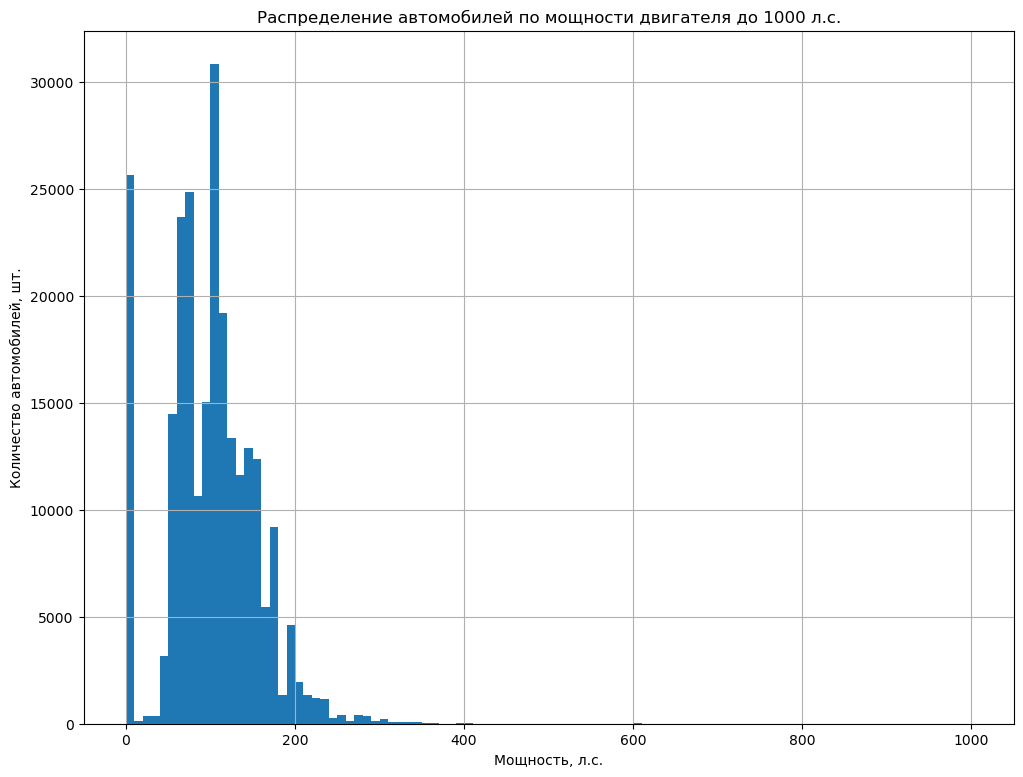

In [25]:
#Раброс очень сильный, усечем выбросы больше 1000 л.с.
filtred_autos_data = filtred_autos_data.query('Power < 1001')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()
plt.title('Распределение автомобилей по мощности двигателя до 1000 л.с.')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей, шт.');

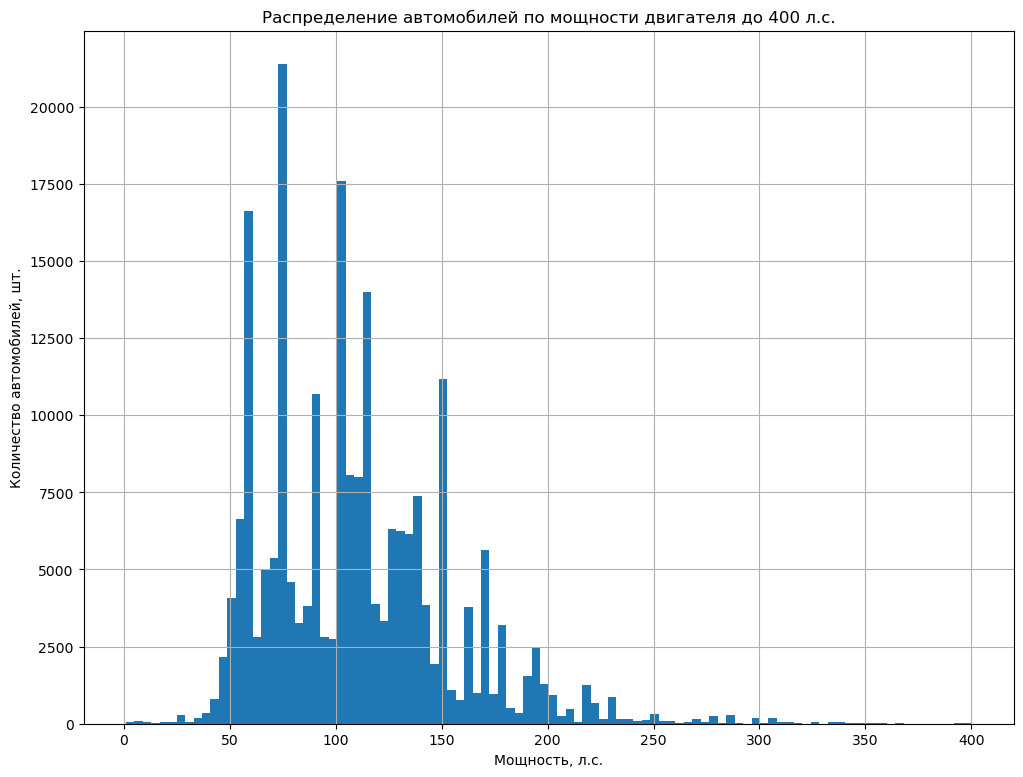

In [26]:
#Из графика видно, что многие машины имеют мощность 0. 
#Эти строки не подлежат восстановлению и будут удалены. 
#По правому отсечению выберем границу в 400 л.с.
filtred_autos_data = filtred_autos_data.query('0 < Power < 401')
filtred_autos_data['Power'].hist(bins=100, figsize=(12,9))
filtred_autos_data['Power'].describe()
plt.title('Распределение автомобилей по мощности двигателя до 400 л.с.')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей, шт.');

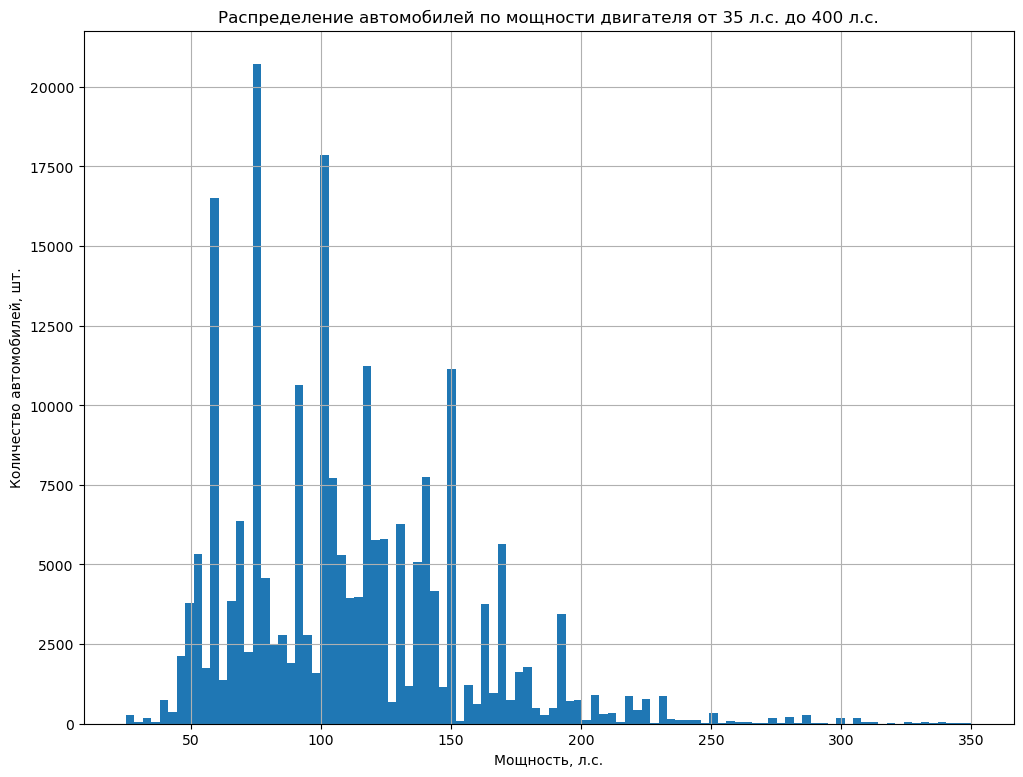

In [27]:
#Следующими границами выберем 25 и 350 л.с.
good_autos_data = filtred_autos_data.query('24 < Power < 351')
good_autos_data['Power'].hist(bins=100, figsize=(12,9))
good_autos_data['Power'].describe()
plt.title('Распределение автомобилей по мощности двигателя от 35 л.с. до 400 л.с.')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество автомобилей, шт.');

In [28]:
good_autos_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221412 entries, 3 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       221412 non-null  object
 1   Gearbox           221412 non-null  object
 2   Power             221412 non-null  int64 
 3   Kilometer         221412 non-null  int64 
 4   FuelType          221412 non-null  object
 5   Brand             221412 non-null  object
 6   Repaired          221412 non-null  object
 7   RegistrationYear  221412 non-null  int64 
 8   Model             221412 non-null  object
 9   Price             221412 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 18.6+ MB


Проведем замену столбцов ***Gearbox*** и ***Repaired*** на *булев тип.*
* ***IsManualGearbox. 1(manual)*** - означает механическую коробку передач. 0(auto) - автоматическую.
* ***IsNotRepaired. 1(yes)*** - означает машину без ремонта. 0(no) - с ремонтом.

**Вывод по шагу 1.**

1. Была изучена таблица данных.
2. Выведены аномальные и пропущенные значения.
3. Отобраны небходимые столбцы для обучения модели.
4. Заполнены пропуски в столбцах и удалены некорректные значения.

## Обучение моделей

In [29]:
#Разбиваем датасет на обучаюищую и тестовую выборки
features=good_autos_data.drop(['Price'],axis=1)
target=good_autos_data['Price']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)
features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)
features_train.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model
0,wagon,manual,131,150000,gasoline,ford,no,2007,mondeo
1,sedan,manual,110,150000,petrol,peugeot,no,1999,3_reihe
2,small,manual,64,150000,petrol,volkswagen,no,2002,polo
3,convertible,manual,133,150000,petrol,audi,no,1992,80
4,small,auto,45,150000,petrol,smart,Repaired,1999,fortwo


In [30]:
#Выберем только категориальные признаки
cat_feature=['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'Repaired']
#Выберем только численные признаки
num_feature=['Power', 'Kilometer', 'RegistrationYear']

In [31]:
#Порядковое кодирование (OE) для обучающей выборки
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(features_train[cat_feature])
features_train_oe = features_train.copy()
features_train_oe[cat_feature] = pd.DataFrame(data = oe.transform(features_train[cat_feature]), columns=features_train[cat_feature].columns)
features_train_oe.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model
0,7.0,1.0,131,150000,4.0,10.0,1.0,2007,152.0
1,4.0,1.0,110,150000,8.0,25.0,1.0,1999,10.0
2,5.0,1.0,64,150000,8.0,38.0,1.0,2002,171.0
3,1.0,1.0,133,150000,8.0,1.0,1.0,1992,20.0
4,5.0,0.0,45,150000,8.0,32.0,0.0,1999,106.0


In [32]:
#Порядковое кодирование (OE) для тестовой выборки
#oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
#oe.fit(features_train[cat_feature])
features_test_oe = features_test.copy()
features_test_oe[cat_feature] = pd.DataFrame(data = oe.transform(features_test[cat_feature]), columns=features_test[cat_feature].columns)
features_test_oe.head()

,VehicleType,Gearbox,Power,Kilometer,FuelType,Brand,Repaired,RegistrationYear,Model
0,7.0,1.0,120,150000,4.0,24.0,1.0,2005,244.0
1,5.0,1.0,75,150000,8.0,38.0,1.0,2000,222.0
2,7.0,1.0,75,150000,8.0,31.0,1.0,2004,101.0
3,4.0,1.0,102,150000,6.0,1.0,0.0,2016,28.0
4,5.0,1.0,60,150000,8.0,24.0,1.0,2005,83.0


In [33]:
#Прямое кодирование (OHE)
ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(features_train[cat_feature])
features_train_ohe = features_train.copy()
columns_list = ohe.get_feature_names()
new_frame = pd.DataFrame(data = ohe.transform(features_train[cat_feature]), index = features_train.index, columns=columns_list)
features_train_ohe = pd.concat((features_train_ohe[num_feature], new_frame), axis=1)
features_train_ohe.head()

,Power,Kilometer,RegistrationYear,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x4_smart,x4_sonstige_autos,x4_subaru,x4_suzuki,x4_toyota,x4_trabant,x4_volkswagen,x4_volvo,x5_no,x5_yes
0,131,150000,2007,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,110,150000,1999,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,64,150000,2002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,133,150000,1992,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,45,150000,1999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Напишем функцию для расчета метрики RMSE и с помощию функции make_scorer создаем метрику RMSE:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### Линейная регрессия

In [35]:
%%time
#Объявляем модель
regression = LinearRegression()
#Обучаем модель
regression.fit(features_train_ohe, target_train)

CPU times: user 11.2 s, sys: 1.01 s, total: 12.2 s
Wall time: 3.79 s


LinearRegression()

In [36]:
%%time
#Определяем RMSE модели с помощью кросс-валидации
regression_score = pd.Series(cross_val_score(regression, features_train_ohe, target_train,scoring=RMSE_score,cv=3)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_score)

Среднее качество модели линейной регрессии на кросс-валидации: 1343.243974429741
CPU times: user 26.9 s, sys: 2.73 s, total: 29.6 s
Wall time: 8.3 s


### Лес решений

In [37]:
%%time
#Объявляем модель
forest = RandomForestRegressor(random_state = 12345)
#Определяем словарь с набором параметров
forest_parametrs = { 'n_estimators': range(10, 100, 200),
                     'max_depth': range(1, 6, 2),
                     'min_samples_leaf': range(1,4),
                     'min_samples_split': range(2,6,2), 
                     }

CPU times: user 313 µs, sys: 6 µs, total: 319 µs
Wall time: 45.1 µs


In [38]:
%%time
#Применяем GridSearchCV с кросс-валидацией
forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=3)
forest_grid.fit(features_train_oe, target_train)

CPU times: user 29.6 s, sys: 464 ms, total: 30.1 s
Wall time: 29 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 6, 2),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(10, 100, 200)},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [39]:
%%time
#Определяем оптимальные гиперпараметры и качество модели на кросс-валидации
forest_params = forest_grid.best_params_
#forest_score = forest_grid.score(features_train_oe, target_train) * (-1)
print(forest_params)
#print(forest_score)

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
CPU times: user 299 µs, sys: 133 µs, total: 432 µs
Wall time: 366 µs


In [40]:
%%time
forest_model = RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=10, random_state=12345)
forest_model_score = (cross_val_score(forest_model, features_train_oe, target_train,scoring=RMSE_score,cv=3)).mean()*(-1)
print('Среднее качество модели леса на кросс-валидации:', forest_model_score)

Среднее качество модели леса на кросс-валидации: 1283.8805312719182
CPU times: user 2.41 s, sys: 28.5 ms, total: 2.44 s
Wall time: 2.44 s


### LGBMRegressor

In [41]:
%%time
#Объявляю модель
lg = LGBMRegressor(random_state = 12345)
#Определяю словарь с набором параметров
lg_parametrs = {"max_depth": [25, 50, 75],
               "learning_rate" : [0.01, 0.1],
               "num_leaves": [500, 1200],
               "n_estimators": range (5, 15, 5),
                             }
#Применяю GridSearchCV с кросс-валидацией
lg_grid = GridSearchCV(lg, lg_parametrs, scoring=RMSE_score, cv=3, verbose=3)
lg_grid.fit(features_train_oe, target_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END learning_rate=0.01, max_depth=25, n_estimators=5, num_leaves=500;, score=-1948.465 total time=   0.3s
[CV 2/3] END learning_rate=0.01, max_depth=25, n_estimators=5, num_leaves=500;, score=-1950.709 total time=   0.3s
[CV 3/3] END learning_rate=0.01, max_depth=25, n_estimators=5, num_leaves=500;, score=-1952.435 total time=   0.3s
[CV 1/3] END learning_rate=0.01, max_depth=25, n_estimators=5, num_leaves=1200;, score=-1946.124 total time=   1.7s
[CV 2/3] END learning_rate=0.01, max_depth=25, n_estimators=5, num_leaves=1200;, score=-1948.430 total time=   2.5s
[CV 3/3] END learning_rate=0.01, max_depth=25, n_estimators=5, num_leaves=1200;, score=-1949.984 total time=   1.3s
[CV 1/3] END learning_rate=0.01, max_depth=25, n_estimators=10, num_leaves=500;, score=-1880.932 total time=   0.5s
[CV 2/3] END learning_rate=0.01, max_depth=25, n_estimators=10, num_leaves=500;, score=-1883.451 total time=   0.7s
[CV 3/3] END l

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [25, 50, 75],
                         'n_estimators': range(5, 15, 5),
                         'num_leaves': [500, 1200]},
             scoring=make_scorer(RMSE, greater_is_better=False), verbose=3)

In [42]:
%%time
#Определяем оптимальные гиперпараметры и качество модели на кросс-валидации
lg_params = lg_grid.best_params_
#lg_score = lg_grid.score(features_train_oe, target_train) * (-1)
print(lg_params)
#print(lg_score)

{'learning_rate': 0.1, 'max_depth': 25, 'n_estimators': 10, 'num_leaves': 1200}
CPU times: user 4.15 ms, sys: 305 µs, total: 4.46 ms
Wall time: 286 µs


In [43]:
%%time
#Определяю качество модели на кросс-валидации
lg_model = LGBMRegressor(learning_rate=0.1, max_depth=25, n_estimators=10, num_leaves=1200, random_state = 12345)
lg_model_score = (cross_val_score(lg_model, features_train_oe, target_train,scoring=RMSE_score,cv=3)).mean()*(-1)
print('Среднее качество модели LGBMR на кросс-валидации:', lg_model_score)

Среднее качество модели LGBMR на кросс-валидации: 1155.7242592749656
CPU times: user 37.7 s, sys: 1.27 s, total: 39 s
Wall time: 2.55 s


### CatBoostRegressor

In [44]:
%%time
#Объявляю модель
cb = CatBoostRegressor(random_state = 12345)
#Определяю словарь с набором параметров
cb_parametrs = {"iterations": [100],
                "depth": range(8, 16, 2),
                "learning_rate" : [0.15],
                             }
#Применяю GridSearchCV с кросс-валидацией
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=3)
cb_grid.fit(features_train_oe, target_train)

0:	learn: 1858.9860302	total: 69.5ms	remaining: 6.88s
1:	learn: 1723.0297963	total: 78ms	remaining: 3.82s
2:	learn: 1615.3379176	total: 86.2ms	remaining: 2.79s
3:	learn: 1521.5858830	total: 94.2ms	remaining: 2.26s
4:	learn: 1446.7694688	total: 102ms	remaining: 1.94s
5:	learn: 1386.8401914	total: 110ms	remaining: 1.73s
6:	learn: 1339.5301124	total: 118ms	remaining: 1.56s
7:	learn: 1300.3552875	total: 126ms	remaining: 1.45s
8:	learn: 1265.1754524	total: 135ms	remaining: 1.37s
9:	learn: 1237.6140186	total: 144ms	remaining: 1.3s
10:	learn: 1213.9784115	total: 153ms	remaining: 1.24s
11:	learn: 1190.9745162	total: 161ms	remaining: 1.18s
12:	learn: 1174.4760304	total: 169ms	remaining: 1.13s
13:	learn: 1154.2757157	total: 177ms	remaining: 1.09s
14:	learn: 1138.3488321	total: 184ms	remaining: 1.04s
15:	learn: 1128.6595658	total: 192ms	remaining: 1.01s
16:	learn: 1114.5267803	total: 199ms	remaining: 973ms
17:	learn: 1105.4038180	total: 207ms	remaining: 942ms
18:	learn: 1096.1969537	total: 215ms	

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f89f210cbe0>,
             param_grid={'depth': range(8, 16, 2), 'iterations': [100],
                         'learning_rate': [0.15]},
             scoring=make_scorer(RMSE, greater_is_better=False))

In [45]:
%%time
#Определяем оптимальные гиперпараметры и качество модели на кросс-валидации
cb_params = cb_grid.best_params_
#cb_score = cb_grid.score(features_train_oe, target_train) * (-1)
print(cb_params)
#print(cb_score)

{'depth': 14, 'iterations': 100, 'learning_rate': 0.15}
CPU times: user 411 µs, sys: 374 µs, total: 785 µs
Wall time: 501 µs


In [46]:
%%time
cbr_model = CatBoostRegressor(depth = 14, iterations = 100, learning_rate = 0.15, random_state = 12345)
cbr_model_score = (cross_val_score(cbr_model, features_train_oe, target_train,scoring=RMSE_score,cv=3)).mean()*(-1)
print('Среднее качество модели catboost на кросс-валидации:', cbr_model_score)

0:	learn: 1836.0634992	total: 127ms	remaining: 12.6s
1:	learn: 1682.0111211	total: 257ms	remaining: 12.6s
2:	learn: 1556.5635236	total: 384ms	remaining: 12.4s
3:	learn: 1456.8627344	total: 514ms	remaining: 12.3s
4:	learn: 1372.6161496	total: 646ms	remaining: 12.3s
5:	learn: 1304.5049345	total: 786ms	remaining: 12.3s
6:	learn: 1247.2535558	total: 929ms	remaining: 12.3s
7:	learn: 1198.0390163	total: 1.07s	remaining: 12.3s
8:	learn: 1160.5934387	total: 1.2s	remaining: 12.1s
9:	learn: 1130.8746740	total: 1.33s	remaining: 12s
10:	learn: 1105.5830111	total: 1.46s	remaining: 11.8s
11:	learn: 1082.6205221	total: 1.59s	remaining: 11.7s
12:	learn: 1064.7142588	total: 1.72s	remaining: 11.5s
13:	learn: 1050.1237708	total: 1.84s	remaining: 11.3s
14:	learn: 1036.3629547	total: 1.97s	remaining: 11.1s
15:	learn: 1021.5717274	total: 2.09s	remaining: 11s
16:	learn: 1009.6751675	total: 2.21s	remaining: 10.8s
17:	learn: 1002.4107576	total: 2.34s	remaining: 10.7s
18:	learn: 995.3226057	total: 2.47s	remaini

**Вывод по шагу 2**

Были изучены 4 модели. Зафиксированы лучшие гиперпараметры и время их выполнения.

## Анализ моделей

In [47]:
%%time
#Для проверки адекватности моделей создаю константную модель
const_model = pd.Series(target_train.median(), index=target_test.index)

#Определяю метрику RMSE константной модели
const_RMSE = round(RMSE(target_test, const_model), 3)
print('RMSE для константной модели', const_RMSE)

RMSE для константной модели 2084.091
CPU times: user 4.46 ms, sys: 1.35 ms, total: 5.81 ms
Wall time: 3.67 ms


In [48]:
columns = ['Модель', 'Время работы модели, сек.', 'RMSE',]
const_model = ['Константная модель', 0, const_RMSE]
regression_model = ['Линейная регрессия', 81, regression_score]
forest_model = ['Случайный лес', 63, forest_model_score]
lg_model = ['LGBMRegressor', 92, 6666]
cb_model = ['CatBoostRegressor', 68, cbr_model_score]

table = pd.DataFrame([const_model, forest_model, regression_model, lg_model, cb_model], columns = columns)
table['Качество по отношению к константной модели, %'] = round((1-table['RMSE']/const_RMSE) * 100, 2)

display(table)

,Модель,"Время работы модели, сек.",RMSE,"Качество по отношению к константной модели, %"
0,Константная модель,0,2084.091000,0.00
1,Случайный лес,63,1283.880531,38.40
2,Линейная регрессия,81,1343.243974,35.55
3,LGBMRegressor,92,6666.000000,-219.85
4,CatBoostRegressor,68,927.778143,55.48


Определяем RMSE лучшей модели по обучающей выборке с лучшими гиперпараметрами

In [49]:
%%time
#Обучаю модель на оптимальных гиперпараметрах
cbr_model_test = CatBoostRegressor(iterations=cb_params['iterations'],
                                learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cbr_model_test.fit(features_train_oe, target_train)
cbr_model_test_predictions = cbr_model_test.predict(features_test_oe)

#Определяю метрику RMSE
cbr_RMSE = round(RMSE(target_test, cbr_model_test_predictions), 3)
print('RMSE модели CatBoostRegressor:', cbr_RMSE)

0:	learn: 1833.2537668	total: 137ms	remaining: 13.6s
1:	learn: 1678.1863761	total: 275ms	remaining: 13.5s
2:	learn: 1551.7003364	total: 409ms	remaining: 13.2s
3:	learn: 1445.3673843	total: 540ms	remaining: 13s
4:	learn: 1362.8539822	total: 672ms	remaining: 12.8s
5:	learn: 1296.3791542	total: 803ms	remaining: 12.6s
6:	learn: 1239.8408052	total: 941ms	remaining: 12.5s
7:	learn: 1190.7396297	total: 1.08s	remaining: 12.4s
8:	learn: 1153.5655265	total: 1.21s	remaining: 12.2s
9:	learn: 1124.3648587	total: 1.34s	remaining: 12.1s
10:	learn: 1095.4670794	total: 1.48s	remaining: 12s
11:	learn: 1072.8025967	total: 1.62s	remaining: 11.9s
12:	learn: 1055.9134335	total: 1.76s	remaining: 11.8s
13:	learn: 1041.0872869	total: 1.89s	remaining: 11.6s
14:	learn: 1030.4901393	total: 2.02s	remaining: 11.5s
15:	learn: 1018.6721403	total: 2.15s	remaining: 11.3s
16:	learn: 1010.3363081	total: 2.28s	remaining: 11.2s
17:	learn: 1000.9499067	total: 2.42s	remaining: 11s
18:	learn: 993.6304853	total: 2.56s	remainin

## Общий вывод

На первом этапе произведена загрузка данных и их подготовка для обучения моделей. Для анализа данных и построения модели предоставлен датасет, содержащий информацию о технических характеристиках, комплектациях и ценах автомобилей, которые размещались на площадке сервиса «Не бит, не крашен» для продажи. Датасет состоит из 16 столбцов с данными и 354369 строк. 
Для обучения моделей требовалась подготовка данных, а именно заполнение пропусков, удаление некоторых аномальных значений, удаление ненужных для обучения моделей столбцов. 
В итоге получен датасет, состоящий из 11 столбцов с данными и 221412 строк.

На втором этапе обучены четыре модели. Определены оптимальные гиперпараметры и показатели метрики RMSE на кросс-валидации. В качестве моделей использованы **Линейная регрессия, Случайный лес, LGBMRegressor, CatBoostRegressor.**

Третий этап позволил произвести анализ качества моделей относительно константной, определены временные рамки работы всех моделей. Для **константной модели** `RMSE=2084` Наименьший показатель метрики `RMSE=927` достигнут при использовании модели **CatBoostRegressor**, поэтому она была выбрана для тестовой выборки, где показала примерно тот же результат (RMSE=931 на тестовой выборке) время обучения этой модели составило *68 секунд.* Модель **LGBMRegressor** также показала неплохой результат с `RMSE=1119`, однако слишком большим временем обучения в *9 минут 35 секунд*.

Для работы рекомендуется применять модель на основе CatBoostRegressor.